# Extraindo e Analisando Dados com a API da FDA (*Food and Drug Administration*) 

## Objetivos
 - Escolher uma API para extração de dados
 - Formatar os dados da API de forma tabular utilizando Pandas
 - Criar gráficos, análises, tabelas, sobre os dados extraídos, utilizando bibliotecas python

### API 

A consulta é estruturada com a URL base da API e parâmetros específicos, como a busca, número de registros e limite, essa consulta tem a forma: 
- https://api.fda.gov/drug/label.json(endpoint base)?search=campo:termo&limit=5(limite).

### Categorias escolhidas

Escolhi essas categorias pois achei seu contexto relevante na análise de dados de sáude

- What adverse reactions are frequently reported?: Essa categoria me permite explorar quais medicamentos apresentam as condições adversas mais frequentemente registradas, o que pode fornecer insights sobre quais medicamentos ou substâncias estão associadas a efeitos colaterais comuns

- Who reports adverse events?: Com essa informação é possível identificar quais fontes estão mais frequentemente relatando os eventos adversos, permitindo uma possível correlação 

- Adverse drug event reports by Country: Essa categoria permite a análise geográfica nas condições adversas em medicamentos 

- Date that the report was first received by FDA: Essa categoria permite avaliar padrões de reporte ao longo do tempo e compreender mudanças e tendências

- The drug’s dosage form.: Essa informação pode ser útil para correlacionar quais formas de administração tem maior probabilidade de causar reações adversas

### Requisição da API escolhida e criação de DataFrames

In [1]:
#Importação das bibliotecas necessárias para a extração da API
import requests
import pandas as pd

In [2]:
#URLs escolhidas para análise: Food and Drug Administration (FDA)
urls = {
    "frequent_adverse_reactions": 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20241219]&count=patient.drug.activesubstance.activesubstancename.exact',
    "adverse_event_reporters": 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20241219]&count=primarysource.qualification',
    "reports_by_country": 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20241219]&count=primarysource.reportercountry.exact',
    "recieve_date": 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20241220]&count=receivedate',
    "drug_dosage_forms": 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20241219]&count=patient.drug.drugdosageform.exact',
}

#Função para extração dos dados da API que realiza uma requisição GET e retorna o JSON, inclui também tratamento de erros
def extracao(url): 
    try: 
        requisicao = requests.get(url, timeout=60)
        requisicao.raise_for_status()
        return requisicao.json()
    except requests.exceptions.RequestException as erro: 
        print(f"Erro ao acessar {url}", {erro})

# Função que itera sobre o dicionário de urls chamando a função extração e retorna a coluna de results da API como um dataframe pandas
def dataframe():
    dados = {}
    for nome, url in urls.items():
        try: 
            arquivo_json = extracao(url)
            if 'results' in arquivo_json and arquivo_json['results']: 
                df = pd.DataFrame(arquivo_json['results'])
                dados[nome] = df
            else: 
                print(f"Erro para a URL: {url}")
        except Exception as erro: 
            print(f"Erro para a url {url} {erro}")
            
    print("Requisições sem erro")
    return dados

#Gerando DataFrames dos dados da API e os armazenando em um dicionário
dados_api = dataframe()

#Itera sbre o dicionário de dataframe e cria uma variável global para acesso 
for nome, df in dados_api.items():
    if df is not None:
        globals()[f"df_{nome}"] = df
        print(f"Variável df_{nome} criada.")
    else: 
        print(f"Erro ao criar o DatFrame {nome}.")

Requisições sem erro
Variável df_frequent_adverse_reactions criada.
Variável df_adverse_event_reporters criada.
Variável df_reports_by_country criada.
Variável df_recieve_date criada.
Variável df_drug_dosage_forms criada.


Durante essa etapa do código, inicialmente fiz a leitura individual de cada URL. No entanto, percebi que o código não estava otimizado, então reescrevi com outra abordagem. Após isso, encontrei dificuldades ao tentar acessar cada DataFrame individualmente, o que me levou a pesquisar sobre variáveis globais e como criá-las a partir de um dicionário. Meu pensamento para essa etapa foi de criar um dicionário contendo todas as urls , em seguida, desenvolver uma função responsável pela leitura dos dados com tratamento de erros. Após isso, implementei uma função para iterar pelas URls e transformar os dados em DataFrames. Por fim, após a dificuldade de acessar cada dataframe de forma individual e global criei uma função para iterar no dicionário de dataframes e criar uma variável para cada dataframe. O principal motivo que me levou a adotar essa abordagem foi que, caso novas URLs sejam adicionadas, o processo se torna mais simples e eficiente

### Primeira análise nos dados 
O objetivo da próxima etapa será analisar os tipos de dados, identificar se há presença de dados ausente e, caso necessário, realizar alterações e manipulações

In [3]:
#Iteração no dicionário de DataFrames e criação de um DataFrame com os tipos de dados de cada um
tipos = {} 
for nome, df in dados_api.items(): 
    tipos[nome] = df.dtypes 
    tipos_df = pd.DataFrame(tipos)

#Iteração no dicionário de DataFrames e verificação se há valores nulos
for nome, df in dados_api.items():
    vazios = df.isnull().sum()
    if vazios.sum() == 0:
        print(f'Não há dados vazios no DataFrame {nome}.')
    else:
        print(f'Dados vazios no DataFrame {nome}:')

tipos_df

Não há dados vazios no DataFrame frequent_adverse_reactions.
Não há dados vazios no DataFrame adverse_event_reporters.
Não há dados vazios no DataFrame reports_by_country.
Não há dados vazios no DataFrame recieve_date.
Não há dados vazios no DataFrame drug_dosage_forms.


,frequent_adverse_reactions,adverse_event_reporters,reports_by_country,recieve_date,drug_dosage_forms
count,int64,int64,int64,int64,int64
term,object,int64,object,NaN,object
time,NaN,NaN,NaN,object,NaN


Nessa etapa foi feita a verificação de valores nulos e tipos dos dados por meio de iteração no dicionário de DataFrames, não foram encontrados valores nulos

### Gráficos, análises, tabelas, sobre os dados extraídos, utilizando bibliotecas python

In [4]:
#Importação das bibliotecas e configuração dos parâmetros do seaborn
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set(
    style='darkgrid',
    context='notebook',
    rc={
        'axes.spines.top': False,
        'axes.spines.right': False
    }
)

#### Medicamentos que apresentam efeitos colaterais comuns mais frequentemente

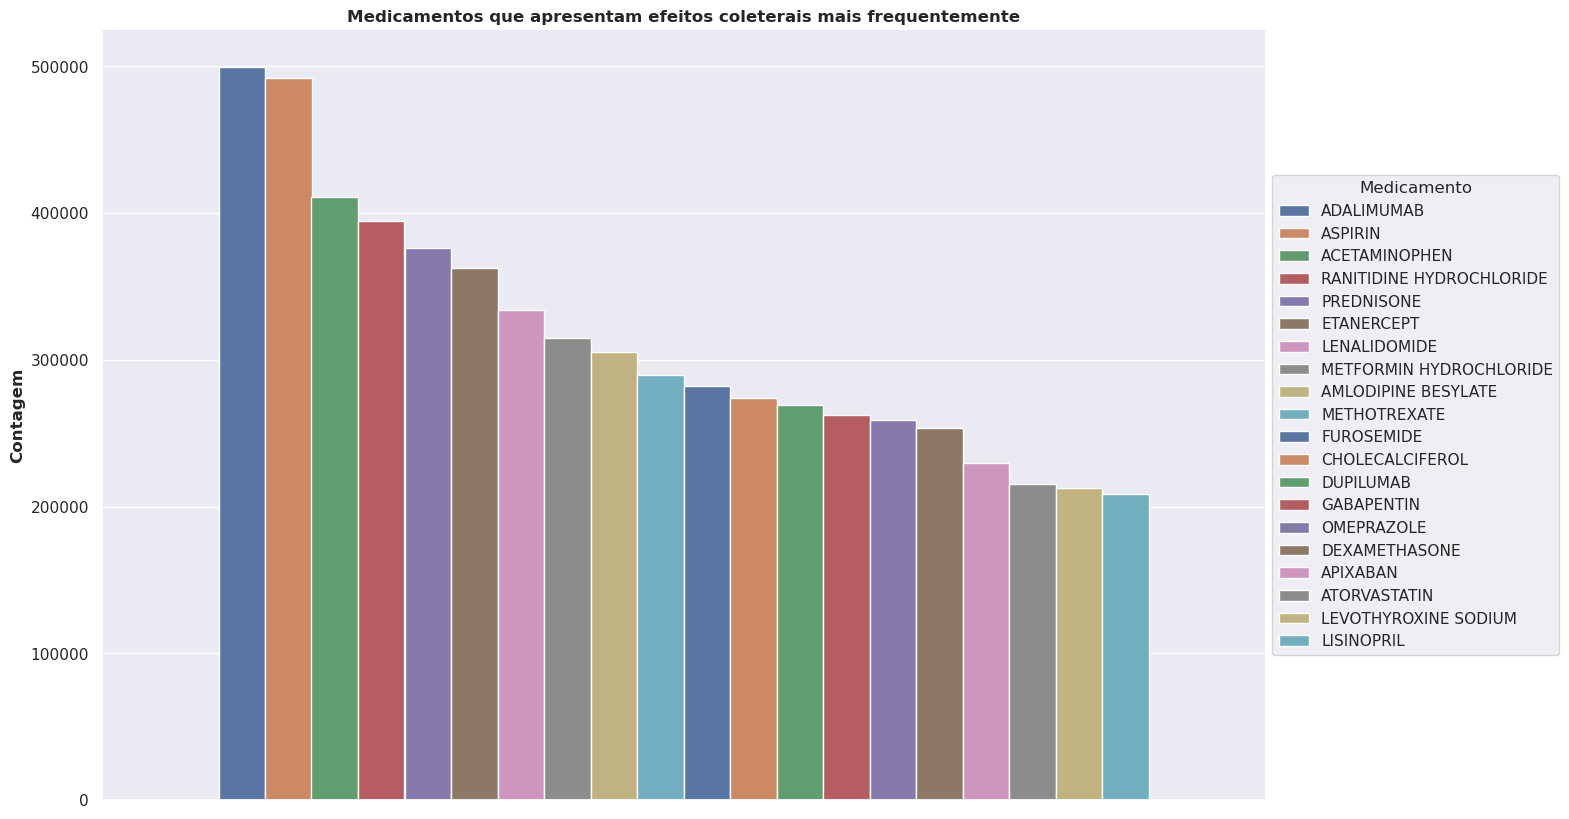

In [5]:
#Função para gerar um gráfico de barra
def barra(df, title, eixoX, eixoY, legenda): 
    df = df.head(20)
    plt.figure(figsize=(15,10))
    grafico_barra = sns.barplot(y='count',data=df, hue='term', palette='deep')
    grafico_barra.set_xlabel(eixoX, fontsize=12, fontweight='bold')
    grafico_barra.set_ylabel(eixoY, fontsize=12, fontweight='bold')
    plt.legend(title=legenda, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title, fontsize=12, fontweight='bold')

#Chamando a função com o dataframe de medicamentos que apresentam efeitos colaterais mais frequentemente
barra(df_frequent_adverse_reactions, 'Medicamentos que apresentam efeitos coleterais mais frequentemente', '', 'Contagem', 'Medicamento')

É possivel observar que alguns medicamentos, como Adalimumab, Aspirin e Acetiminophen, tem a sua frequência alta, indicando que esses medicamentos estão frequentemente associados a reações adversas reportadas. Essa alta frequência pode indicar que esses medicamentos são mais receitados que outros, ou que, de fato os mesmos realmente tem maior probabilidade de causar reações adversas

### Quem reporta as condições adversas a FDA

##### Tratamento de dados e renomeação de colunas para gerar o gráfico posteriormente

In [6]:
#Transformaçao da coluna term para string 
df_adverse_event_reporters['term'] = df_adverse_event_reporters['term'].astype(str)

In [7]:
#Conversão do nome das colunas term
df_adverse_event_reporters['term'] = df_adverse_event_reporters['term'].map({
    "5": "Consumer or non-health professional",
    "1": "Physician",
    "3": "Other health professional",
    "2": "Pharmacist",
    "4": "Lawyer"
})

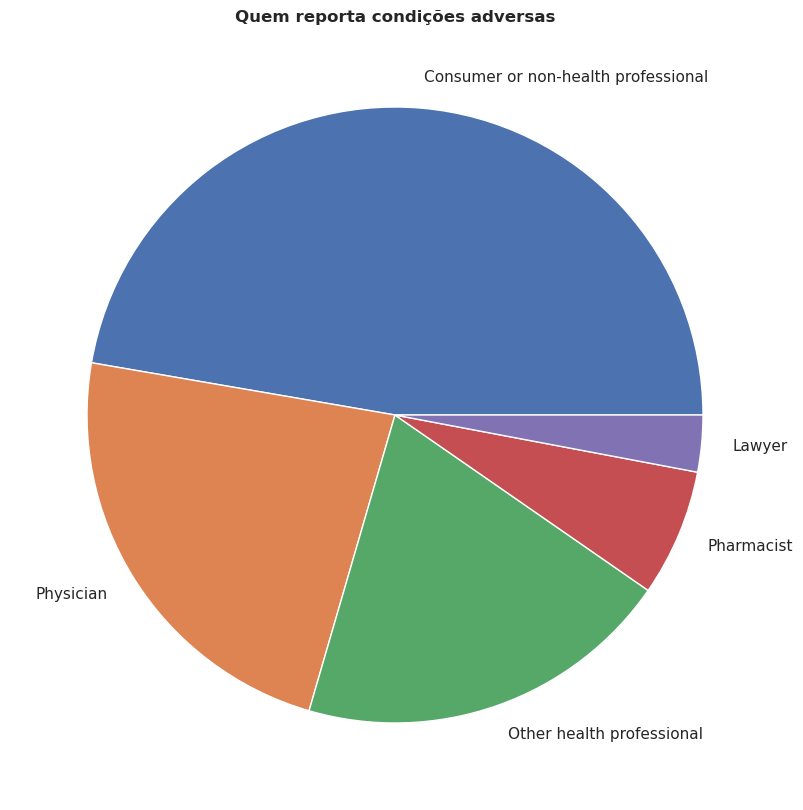

In [8]:
#Função para gerar gráfico de setores
def gerar_setores(df, title): 
    plt.figure(figsize=(15,10))
    plt.pie(df['count'], labels=df['term'])
    plt.title(title, fontsize=12, fontweight='bold')

gerar_setores(df_adverse_event_reporters, 'Quem reporta condições adversas')

O gráfico revela que a maioria dos eventos adversos é reportada por consumidores ou profissionais fora da área da saúde. Médicos ocupam o segundo lugar, como esperado, dado seu contato direto com os pacientes. Já a categoria "Lawyer" chama atenção, pois sugere que questões legais relacionadas a reações adversas são mais frequentes do que se poderia prever, indicando a correlação jurídica com reações adversas de medicamentos

Durante a criação do gráfico de setores, enfrentei dificuldades para renomear os valores da coluna que vieram codificados, provavelmente utilizando algum tipo de Enconder, com números de 1 a 5. Inicialmente, tentei usar o método rename da biblioteca Pandas, mas não tive sucesso. Em seguida, alterei o tipo dos dados para str mas não resolveu o problema. Após consultar a documentação do Pandas, descobri o metódo map, que finalmente mudou os valores da coluna

### Reporte de condições adversas por países

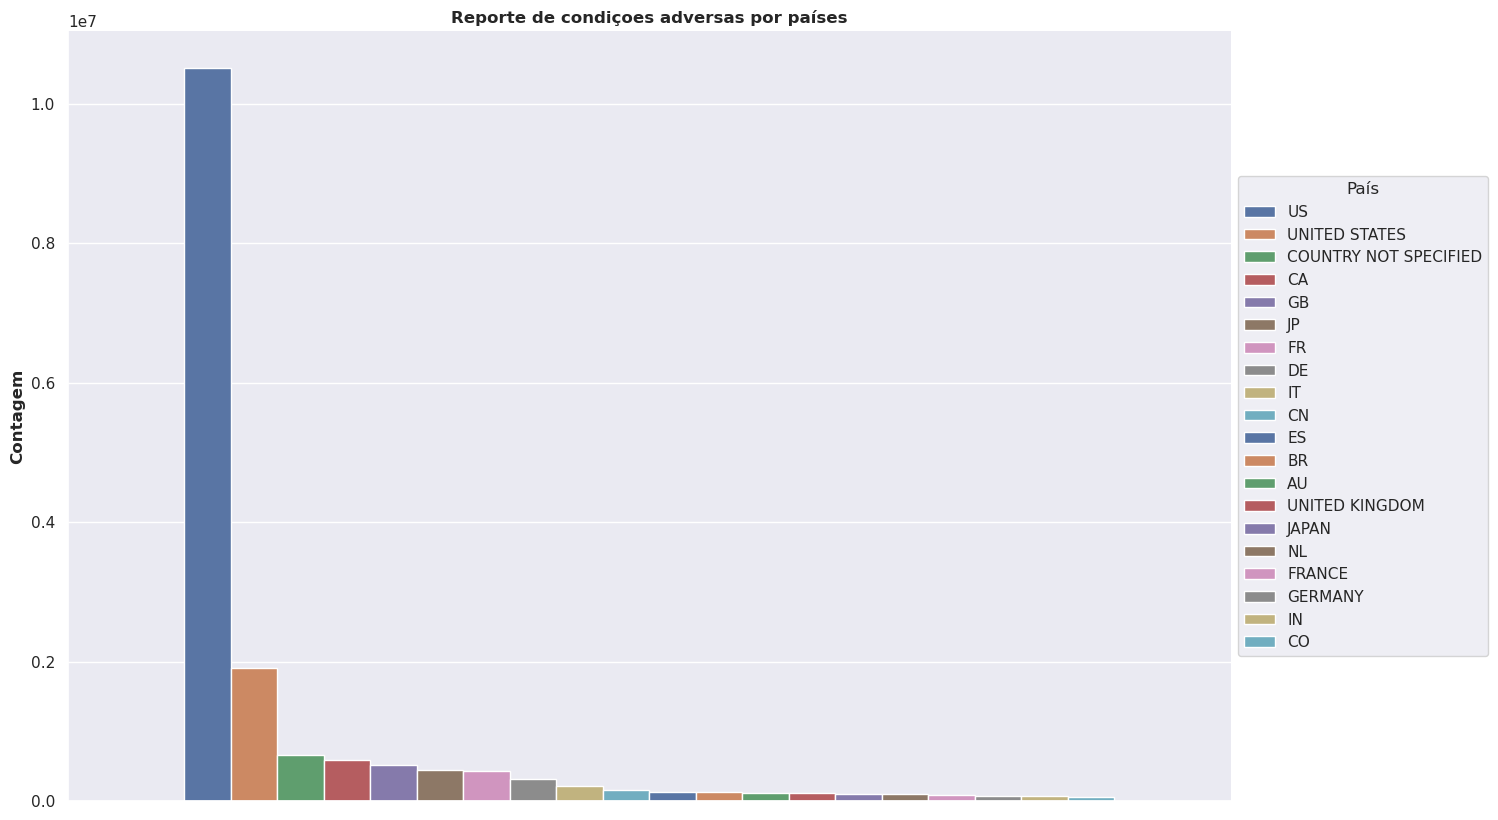

In [9]:
#Utilizando a função para gerar gráfico de barras criada anteriormente, dessa fez com o DataFrame de reporte de condições adversas por países
barra(df_reports_by_country, 'Reporte de condiçoes adversas por países', '', 'Contagem', 'País')

É evidente que os Estados Unidos possuem o maior número de relatos de reações adversas de forma esmagadora, o que pode indicar tanto uma coleta de dados mais eficiente quanto uma maior incidência de reações adversas. Além disso, o fato dos Estados Unidos serem uma potência pode levar a maior acesso a medicamentos pela população e consequentemente um aumento nas reações adversas reportadas

### Contagem de reportes de reações adversas ao longo dos anos

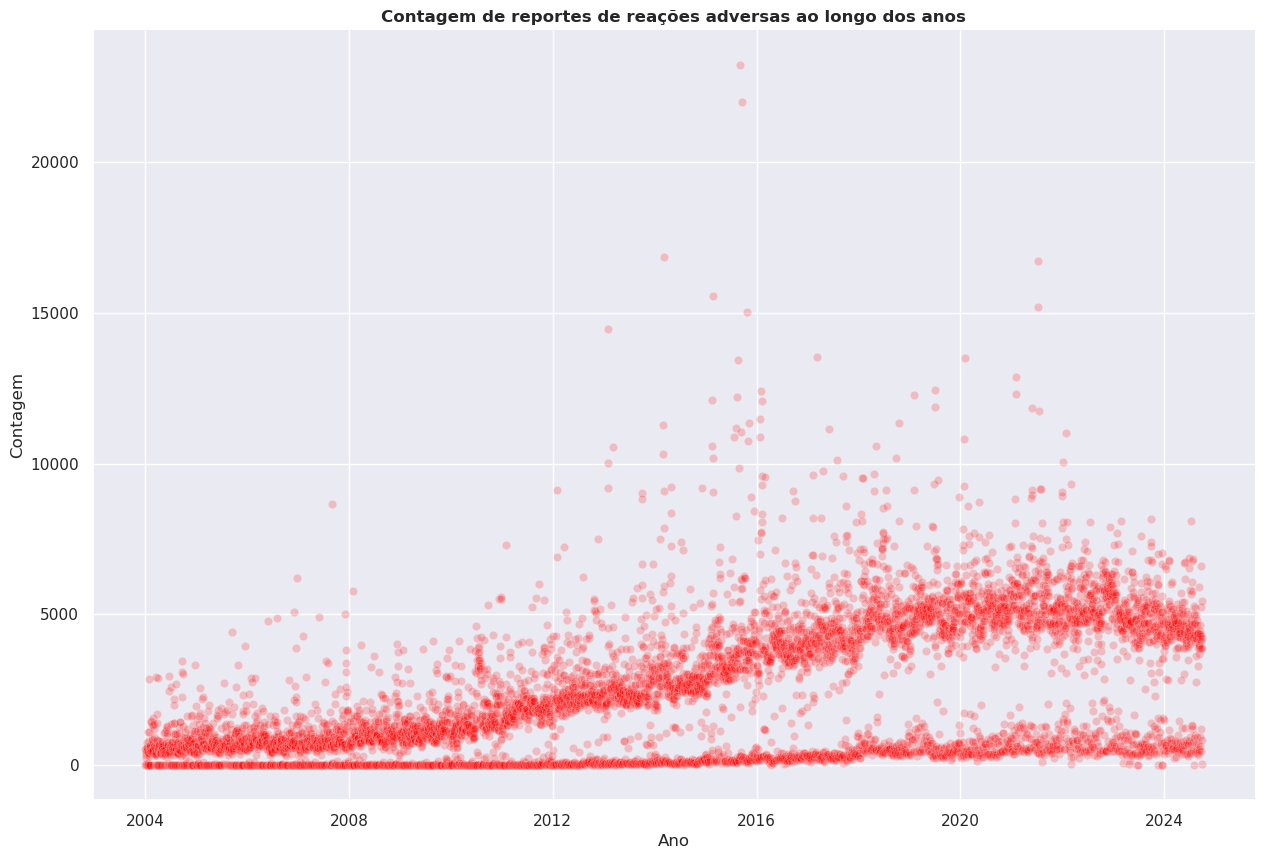

In [10]:
#Convertendo a coluna time para o formato datetime 
df_recieve_date['time'] = pd.to_datetime(df_recieve_date['time']) 

#Função para gerar um gráfico de dispersão 
def gerar_scatter(df): 
    plt.figure(figsize=(15,10))
    scatter_plot = sns.scatterplot(data=df, x='time', y='count', color='red', alpha=0.2)
    scatter_plot.set_xlabel('Ano')
    scatter_plot.set_ylabel('Contagem')
    plt.title('Contagem de reportes de reações adversas ao longo dos anos', fontsize=12, fontweight='bold')

#Chamando a função de gerar gráfico de dispersão com o DataFrame de reportes de condições adversas ao longo dos anos   
gerar_scatter(df_recieve_date) 

Observa-se que os relatos aumentaram de forma contínua desde 2004, alcançando seu pico em 2020, e depois começaram a diminuir. Essa comportamente provavelmente está relacionado à pandemia de COVID-19, que gerou um maior monitoramento e atenção aos efeitos adversos de medicamentos e vacinas

### Formas de dosagem que mais apresentam condições adversas

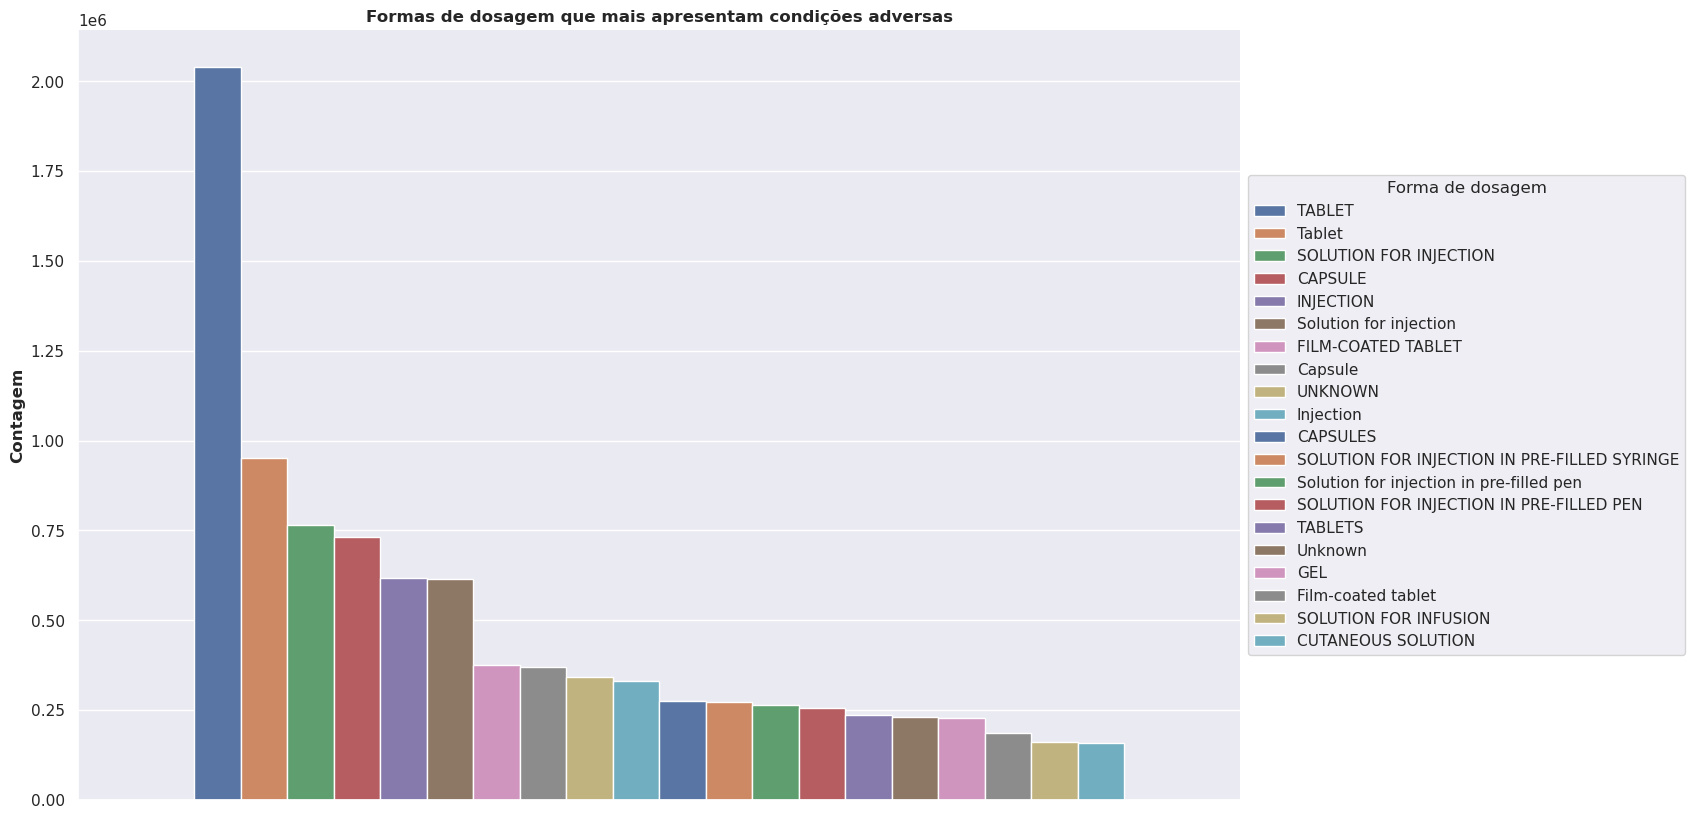

In [11]:
#Chamando a função de geração de gráficos de barra criada anteriormente dessa vez com o DataFrame de formas de dosagem
barra(df_drug_dosage_forms, 'Formas de dosagem que mais apresentam condições adversas', '', 'Contagem', 'Forma de dosagem')

O gráfico mostra que medicamentos na forma de tablet dominam o número de reportes de reações adversas, essa predominância pode ser explicada pela maior popularidade dos medicamentos em formato de comprimido que são mais comumente receitados ou também pode indicar que esses medicamentos apresentam mais condições adversas. Vale ressaltar que, embora os tablets sejam mais populares, o número de reações adversas pode indicar uma maior propensão desses medicamentos a reações adversas

No final, ao gerar o arquivo .py, encontrei dificuldades para definir os títulos de cada gráfico. Para contornar isso, adicionei um parâmetro chamado title em todas funções de criação de gráficos. Dessa forma, cada chamada de função passou a receber seu título específico. Além disso, percebi que havia esquecido de definir as legendas e nomes dos eixos individualmente, o que só notei quando executei o arquivo .py. Para corrigir isso, adicionei parâmetros adicionais, um para a legenda e outros para os rótulos dos eixos

## O código completo se encontra no arquivo main.py